<a href="https://colab.research.google.com/github/soutrik71/School_of_AI_ERA/blob/main/session7/Session7Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is used to solve the assignment for the 7th session of the course. This is the final notebook after a lot of experimentations.
Below specified are a few key assumptions that we take into consideration.
1. For the first block we use 2 Cnn layers as a result of experiments rf=5 is the best to apply the first transition layer
2. In the transition layer we apply the (1,1) first and then maxpooling which we call as combine and compress
3. We try to keep the model param size under ~ 8/8.5k and epoch under 15

## Helper Elements

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [1]:
!pip install portalocker
!pip install torchview
!pip install torcheval
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.7 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchview import draw_graph
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from torcheval.metrics import MulticlassAccuracy,BinaryAccuracy
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, OneCycleLR, ExponentialLR

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [5]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=5,
                       fig_size=(16, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()

In [6]:
# decorator function to record time exp
from functools import wraps
import time

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

In [7]:
# Set manual seed since nn.Parameter are randomly initialzied
set_seed(42)
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 1024
epochs = 15
lr = 1e-3

Random seed set as 42
cuda


## Data Read and Preprocess

In [8]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])


In [9]:
# downloading train and test data
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 100531997.39it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 112579641.10it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39333053.12it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 6882416.46it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [10]:
#Dataloaders
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if device.type == 'cuda' else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


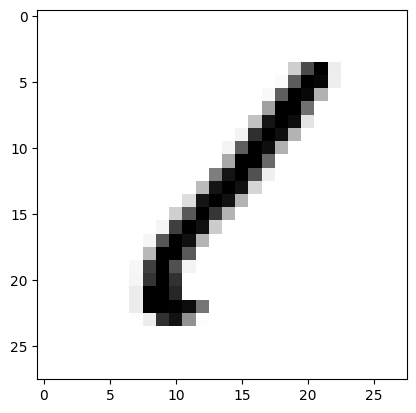

In [11]:
## Basic Data Statistics
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


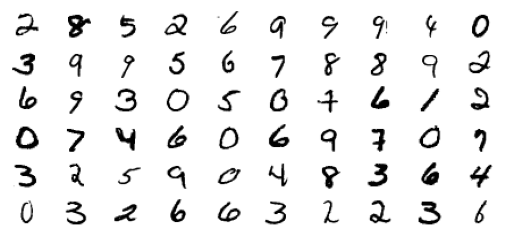

In [12]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Basic Model Setup
* Basic Cnn Model under the guidelines
* Application of Batchnorm as first step to regularization
* Application of Cnn as the final classification layer

In [18]:
class Mnist_Baseline(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Baseline, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #24,6
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #12,6
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #10,10
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #8,14
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #6,18
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        #set-4
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #4,22
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
    )

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=4, stride=1, padding=0))


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition(x)
      x = self.conv2(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [19]:
# New Model Instance
baseline_model = Mnist_Baseline(in_channels=1,hidden_units=12,out_channels=10).to(device)
summary(baseline_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]           1,308
       BatchNorm2d-5           [-1, 12, 24, 24]              24
              ReLU-6           [-1, 12, 24, 24]               0
            Conv2d-7           [-1, 12, 24, 24]             156
       BatchNorm2d-8           [-1, 12, 24, 24]              24
              ReLU-9           [-1, 12, 24, 24]               0
        MaxPool2d-10           [-1, 12, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]           1,308
      BatchNorm2d-12           [-1, 12, 10, 10]              24
             ReLU-13           [-1, 12, 10, 10]               0
           Conv2d-14             [-1, 1

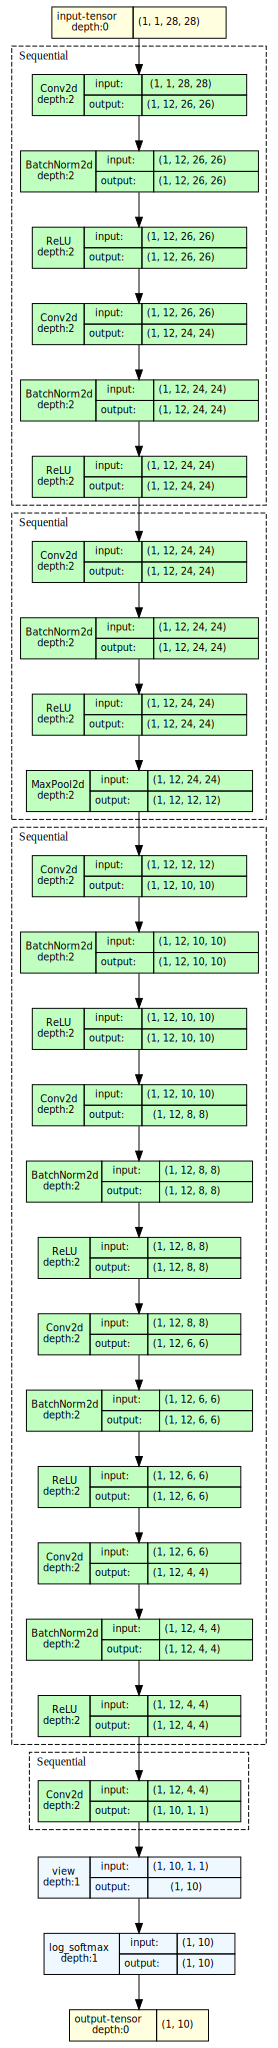

In [20]:
# graphical representation of the model architecture
model_graph = draw_graph(baseline_model, input_size=(1,1, 28, 28), expand_nested=True)
model_graph.resize_graph(scale=10)
model_graph.visual_graph

In [21]:
# updated training module---
@timeit
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for idx, (data,label) in enumerate(pbar):
    # setting up device
    data = data.to(device)
    label = label.to(device)

    # forward pass output
    preds = model(data)

    # calc loss
    loss = criterion(preds, label)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    optimizer.step() # optimizer step -> minima

    # metric calc
    preds = torch.argmax(preds,dim=1)
    # print(f"preds:: {preds}")
    metric.update(preds,label)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [22]:
# updated testing modules---
@timeit
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for idx, (data,label) in enumerate(pbar):
      data , label = data.to(device), label.to(device)
      # predictions
      preds = model(data)
      # print(preds.shape)
      # print(label.shape)

      #loss calc
      loss = criterion(preds, label)
      test_loss += loss.item()

      # metric calc
      preds = torch.argmax(preds,dim=1)
      metric.update(preds,label)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [23]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)

In [24]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.2986378018249835 Avg Train Metric: 0.8092362558218971: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]


Function Took 20.1813 seconds


Avg Test Loss: 0.06780259069526874 Avg Test Metric: 0.9801386979561818: 100%|██████████| 79/79 [00:03<00:00, 26.00it/s]


Function Took 3.0501 seconds
Epoch 1


Avg Train Loss: 0.057823663336167265 Avg Train Metric: 0.9821715607826136: 100%|██████████| 469/469 [00:19<00:00, 24.46it/s]


Function Took 19.1870 seconds


Avg Test Loss: 0.04726444594738887 Avg Test Metric: 0.9837311317649069: 100%|██████████| 79/79 [00:02<00:00, 29.33it/s]


Function Took 2.7001 seconds
Epoch 2


Avg Train Loss: 0.043327810915945564 Avg Train Metric: 0.9874869452864885: 100%|██████████| 469/469 [00:17<00:00, 26.76it/s]


Function Took 17.5388 seconds


Avg Test Loss: 0.04337791872175434 Avg Test Metric: 0.9842973653274246: 100%|██████████| 79/79 [00:02<00:00, 34.39it/s]


Function Took 2.3077 seconds
Epoch 3


Avg Train Loss: 0.03539531875147558 Avg Train Metric: 0.9891170037072351: 100%|██████████| 469/469 [00:18<00:00, 24.84it/s]


Function Took 18.8862 seconds


Avg Test Loss: 0.036620656827087456 Avg Test Metric: 0.9873603582382202: 100%|██████████| 79/79 [00:02<00:00, 35.47it/s]


Function Took 2.2324 seconds
Epoch 4


Avg Train Loss: 0.031165338151141017 Avg Train Metric: 0.9906810603416296: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]


Function Took 17.2984 seconds


Avg Test Loss: 0.036541674608848045 Avg Test Metric: 0.9869906012016006: 100%|██████████| 79/79 [00:02<00:00, 34.47it/s]


Function Took 2.3081 seconds
Epoch 5


Avg Train Loss: 0.02760564338148776 Avg Train Metric: 0.9911122670305818: 100%|██████████| 469/469 [00:18<00:00, 25.53it/s]


Function Took 18.3795 seconds


Avg Test Loss: 0.029719877273398393 Avg Test Metric: 0.9920037019101879: 100%|██████████| 79/79 [00:02<00:00, 33.55it/s]


Function Took 2.3631 seconds
Epoch 6


Avg Train Loss: 0.02514413163077825 Avg Train Metric: 0.992596037352263: 100%|██████████| 469/469 [00:18<00:00, 25.19it/s]


Function Took 18.6297 seconds


Avg Test Loss: 0.027581260355389853 Avg Test Metric: 0.9903169115887412: 100%|██████████| 79/79 [00:03<00:00, 25.51it/s]


Function Took 3.1050 seconds
Epoch 7


Avg Train Loss: 0.02184474770091911 Avg Train Metric: 0.9935220702370601: 100%|██████████| 469/469 [00:17<00:00, 27.20it/s]


Function Took 17.2464 seconds


Avg Test Loss: 0.030782722291843142 Avg Test Metric: 0.9917029708246642: 100%|██████████| 79/79 [00:02<00:00, 32.37it/s]


Function Took 2.4485 seconds
Epoch 8


Avg Train Loss: 0.019934046801416947 Avg Train Metric: 0.9941217319797605: 100%|██████████| 469/469 [00:18<00:00, 25.90it/s]


Function Took 18.1150 seconds


Avg Test Loss: 0.030196609426454843 Avg Test Metric: 0.991044313092775: 100%|██████████| 79/79 [00:02<00:00, 30.74it/s]


Function Took 2.5811 seconds
Epoch 9


Avg Train Loss: 0.019352035934422245 Avg Train Metric: 0.9943953662284656: 100%|██████████| 469/469 [00:17<00:00, 26.85it/s]


Function Took 17.4775 seconds


Avg Test Loss: 0.03634690179465975 Avg Test Metric: 0.9892619591725024: 100%|██████████| 79/79 [00:02<00:00, 35.63it/s]


Function Took 2.2266 seconds
Epoch 10


Avg Train Loss: 0.01781754868615395 Avg Train Metric: 0.9943216385871871: 100%|██████████| 469/469 [00:18<00:00, 25.20it/s]


Function Took 18.6170 seconds


Avg Test Loss: 0.028469627018711422 Avg Test Metric: 0.9906110001515739: 100%|██████████| 79/79 [00:02<00:00, 34.13it/s]


Function Took 2.3209 seconds
Epoch 11


Avg Train Loss: 0.015618731719635324 Avg Train Metric: 0.995635234343726: 100%|██████████| 469/469 [00:17<00:00, 26.88it/s]


Function Took 17.4628 seconds


Avg Test Loss: 0.029253691706741584 Avg Test Metric: 0.9899078215224834: 100%|██████████| 79/79 [00:03<00:00, 22.88it/s]


Function Took 3.4638 seconds
Epoch 12


Avg Train Loss: 0.016562731543268913 Avg Train Metric: 0.9948351224348235: 100%|██████████| 469/469 [00:18<00:00, 25.59it/s]


Function Took 18.3335 seconds


Avg Test Loss: 0.02780316952730918 Avg Test Metric: 0.9898801981648312: 100%|██████████| 79/79 [00:02<00:00, 35.20it/s]


Function Took 2.2563 seconds
Epoch 13


Avg Train Loss: 0.01518964383595768 Avg Train Metric: 0.9961290003648445: 100%|██████████| 469/469 [00:17<00:00, 26.44it/s]


Function Took 17.7460 seconds


Avg Test Loss: 0.027326729006054398 Avg Test Metric: 0.9917674909664106: 100%|██████████| 79/79 [00:03<00:00, 24.66it/s]


Function Took 3.2106 seconds
Epoch 14


Avg Train Loss: 0.013966951865642301 Avg Train Metric: 0.9950562781616569: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]


Function Took 17.5222 seconds


Avg Test Loss: 0.027051369149733006 Avg Test Metric: 0.9902219727069517: 100%|██████████| 79/79 [00:02<00:00, 35.51it/s]

Function Took 2.2327 seconds


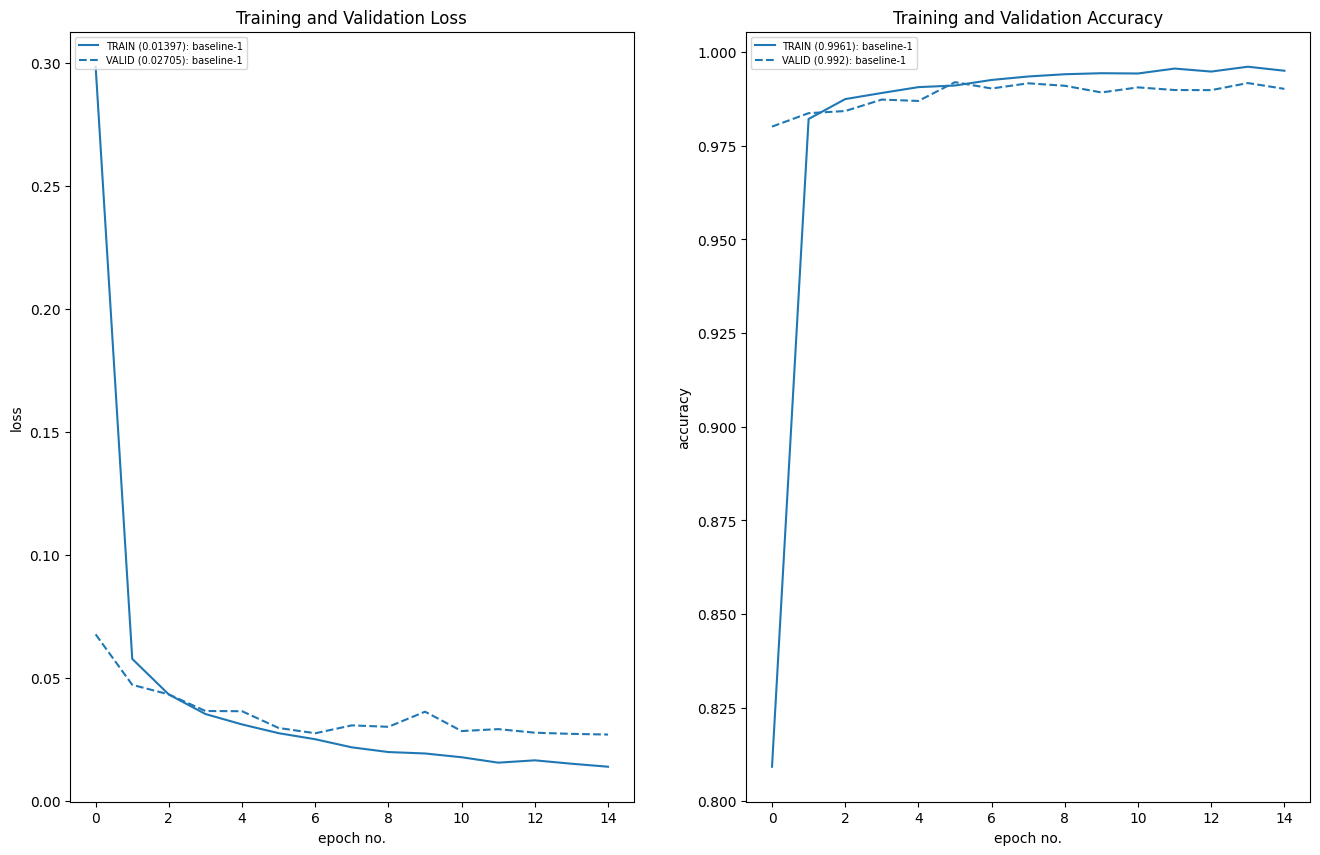

In [25]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline-1'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

Target:

1. Setting up the basic premise for model development
2. Baselin model with 2 sets of convolution blocks and 1 transition block
3. Application of only Batch normalization after every Cnn layer
4. Transition block applied after RF==5

Results:\
Parameters: 8.9k\
Best Training Accuracy: 99.61\
Best Test Accuracy: 99.20

Analysis:
1. As a Baseline model extremely effective with consistent results ie Accuracy>99 for both train & test
2. Diverging gap between both loss metrics of Train & Test

## Overfitting Killer
* Application of dropout layers to solve the problem of overfitting
* In experiments dropout was tried at block level and also layer level and the former was found to be more effective

In [27]:
class Mnist_Baseline_Dropout(nn.Module):

  def __init__(self, in_channels, hidden_units, out_channels):
    super(Mnist_Baseline_Dropout, self).__init__()

    # 3 sets of convolution blocks with batchnorm added
    self.conv1 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #26,3
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,  kernel_size=3, stride=1, padding=0), #24,5
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    # transition block with 1,1 mixer and maxpool added after it ie condense and compress
    self.transition = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=1, stride=1, padding=0), #24,6
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) #12,6
    )

    # 3 sets of convolution blocks with batchnorm added
    self.conv2 = nn.Sequential(
        # set-1
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #10,10
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-2
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #8,14
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-3
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #6,18
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        #set-4
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0), #4,22
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Dropout(p=0.1),
    )

    self.classifier = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=4, stride=1, padding=0))


  def forward(self, x):
      x = self.conv1(x)
      x = self.transition(x)
      x = self.conv2(x)
      x = self.classifier(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [29]:
# New Model Instance
baseline_model_2 = Mnist_Baseline_Dropout(in_channels=1,hidden_units=12,out_channels=10).to(device)
summary(baseline_model_2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,308
       BatchNorm2d-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 12, 24, 24]             156
      BatchNorm2d-10           [-1, 12, 24, 24]              24
             ReLU-11           [-1, 12, 24, 24]               0
        MaxPool2d-12           [-1, 12, 12, 12]               0
           Conv2d-13           [-1, 12, 10, 10]           1,308
      BatchNorm2d-14           [-1, 12,

In [30]:
# driver setup----
# optmizer
optimizer = optim.Adam(baseline_model_2.parameters(), lr=lr)
# loss
criterion = nn.CrossEntropyLoss()
# metric
metric = MulticlassAccuracy(device = device, num_classes=10)

In [31]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0,epochs):
  print(f'Epoch {epoch}')
  train_losses, train_metrics = train_module(baseline_model_2, device, train_loader, optimizer, criterion, metric, train_losses, train_metrics)
  test_losses , test_metrics = test_module(baseline_model_2, device, test_loader, criterion, metric, test_losses, test_metrics)

Epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Avg Train Loss: 0.4469337827091151 Avg Train Metric: 0.7211955099154129: 100%|██████████| 469/469 [00:19<00:00, 24.33it/s]


Function Took 19.2802 seconds


Avg Test Loss: 0.09873904085046128 Avg Test Metric: 0.9702320702468292: 100%|██████████| 79/79 [00:02<00:00, 36.04it/s]


Function Took 2.1975 seconds
Epoch 1


Avg Train Loss: 0.09620239464903692 Avg Train Metric: 0.9681225782518448: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s]


Function Took 17.3516 seconds


Avg Test Loss: 0.059870537087509904 Avg Test Metric: 0.9825304565550406: 100%|██████████| 79/79 [00:02<00:00, 35.93it/s]


Function Took 2.2062 seconds
Epoch 2


Avg Train Loss: 0.0704014442428184 Avg Train Metric: 0.9776249449136161: 100%|██████████| 469/469 [00:19<00:00, 24.51it/s]


Function Took 19.1470 seconds


Avg Test Loss: 0.03658211241252249 Avg Test Metric: 0.9907987110222443: 100%|██████████| 79/79 [00:02<00:00, 35.93it/s]


Function Took 2.2065 seconds
Epoch 3


Avg Train Loss: 0.059107019166861265 Avg Train Metric: 0.9820423321937447: 100%|██████████| 469/469 [00:17<00:00, 27.35it/s]


Function Took 17.1525 seconds


Avg Test Loss: 0.04102815318664041 Avg Test Metric: 0.9883622821373276: 100%|██████████| 79/79 [00:02<00:00, 33.27it/s]


Function Took 2.3885 seconds
Epoch 4


Avg Train Loss: 0.05433312237266697 Avg Train Metric: 0.9834925960630242: 100%|██████████| 469/469 [00:19<00:00, 24.50it/s]


Function Took 19.1511 seconds


Avg Test Loss: 0.043232350745768866 Avg Test Metric: 0.9849085853069643: 100%|██████████| 79/79 [00:02<00:00, 34.45it/s]


Function Took 2.3003 seconds
Epoch 5


Avg Train Loss: 0.04827989981984342 Avg Train Metric: 0.9850054653977026: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]


Function Took 17.5246 seconds


Avg Test Loss: 0.03534238557390208 Avg Test Metric: 0.9878970203520376: 100%|██████████| 79/79 [00:02<00:00, 28.39it/s]


Function Took 2.7901 seconds
Epoch 6


Avg Train Loss: 0.04717924132365296 Avg Train Metric: 0.9853691795487394: 100%|██████████| 469/469 [00:17<00:00, 26.38it/s]


Function Took 17.7847 seconds


Avg Test Loss: 0.02906794305684493 Avg Test Metric: 0.9906689358662956: 100%|██████████| 79/79 [00:02<00:00, 35.09it/s]


Function Took 2.2573 seconds
Epoch 7


Avg Train Loss: 0.042823538719328924 Avg Train Metric: 0.9869073229049569: 100%|██████████| 469/469 [00:17<00:00, 26.48it/s]


Function Took 17.7237 seconds


Avg Test Loss: 0.02909539774343183 Avg Test Metric: 0.9916595824157135: 100%|██████████| 79/79 [00:03<00:00, 26.13it/s]


Function Took 3.0288 seconds
Epoch 8


Avg Train Loss: 0.04150130183372432 Avg Train Metric: 0.987350381132382: 100%|██████████| 469/469 [00:17<00:00, 26.53it/s]


Function Took 17.6870 seconds


Avg Test Loss: 0.028578838159601334 Avg Test Metric: 0.9910919145692753: 100%|██████████| 79/79 [00:02<00:00, 34.99it/s]


Function Took 2.2644 seconds
Epoch 9


Avg Train Loss: 0.03920100321387574 Avg Train Metric: 0.9868620951800967: 100%|██████████| 469/469 [00:18<00:00, 24.83it/s]


Function Took 18.8974 seconds


Avg Test Loss: 0.02613847448396249 Avg Test Metric: 0.993008099779298: 100%|██████████| 79/79 [00:02<00:00, 27.84it/s]


Function Took 2.8445 seconds
Epoch 10


Avg Train Loss: 0.03760771609511155 Avg Train Metric: 0.9879435688447851: 100%|██████████| 469/469 [00:17<00:00, 26.71it/s]


Function Took 17.5676 seconds


Avg Test Loss: 0.025068215426069365 Avg Test Metric: 0.9909485736979714: 100%|██████████| 79/79 [00:02<00:00, 35.84it/s]


Function Took 2.2140 seconds
Epoch 11


Avg Train Loss: 0.03844297370925021 Avg Train Metric: 0.9881297014415391: 100%|██████████| 469/469 [00:18<00:00, 24.90it/s]


Function Took 18.8434 seconds


Avg Test Loss: 0.02782243902535661 Avg Test Metric: 0.9927384415759316: 100%|██████████| 79/79 [00:02<00:00, 35.53it/s]


Function Took 2.2321 seconds
Epoch 12


Avg Train Loss: 0.03620558568506813 Avg Train Metric: 0.9884489195179075: 100%|██████████| 469/469 [00:17<00:00, 26.70it/s]


Function Took 17.5765 seconds


Avg Test Loss: 0.026315832112715404 Avg Test Metric: 0.9924538973011549: 100%|██████████| 79/79 [00:02<00:00, 29.21it/s]


Function Took 2.7167 seconds
Epoch 13


Avg Train Loss: 0.03473935504781523 Avg Train Metric: 0.9883078386280328: 100%|██████████| 469/469 [00:17<00:00, 26.28it/s]


Function Took 17.8541 seconds


Avg Test Loss: 0.026327962524410855 Avg Test Metric: 0.9924689569050753: 100%|██████████| 79/79 [00:02<00:00, 33.83it/s]


Function Took 2.3431 seconds
Epoch 14


Avg Train Loss: 0.034592379864279446 Avg Train Metric: 0.9890040389256183: 100%|██████████| 469/469 [00:17<00:00, 26.41it/s]


Function Took 17.7689 seconds


Avg Test Loss: 0.024515276468252835 Avg Test Metric: 0.9919412717034545: 100%|██████████| 79/79 [00:02<00:00, 26.86it/s]

Function Took 2.9503 seconds


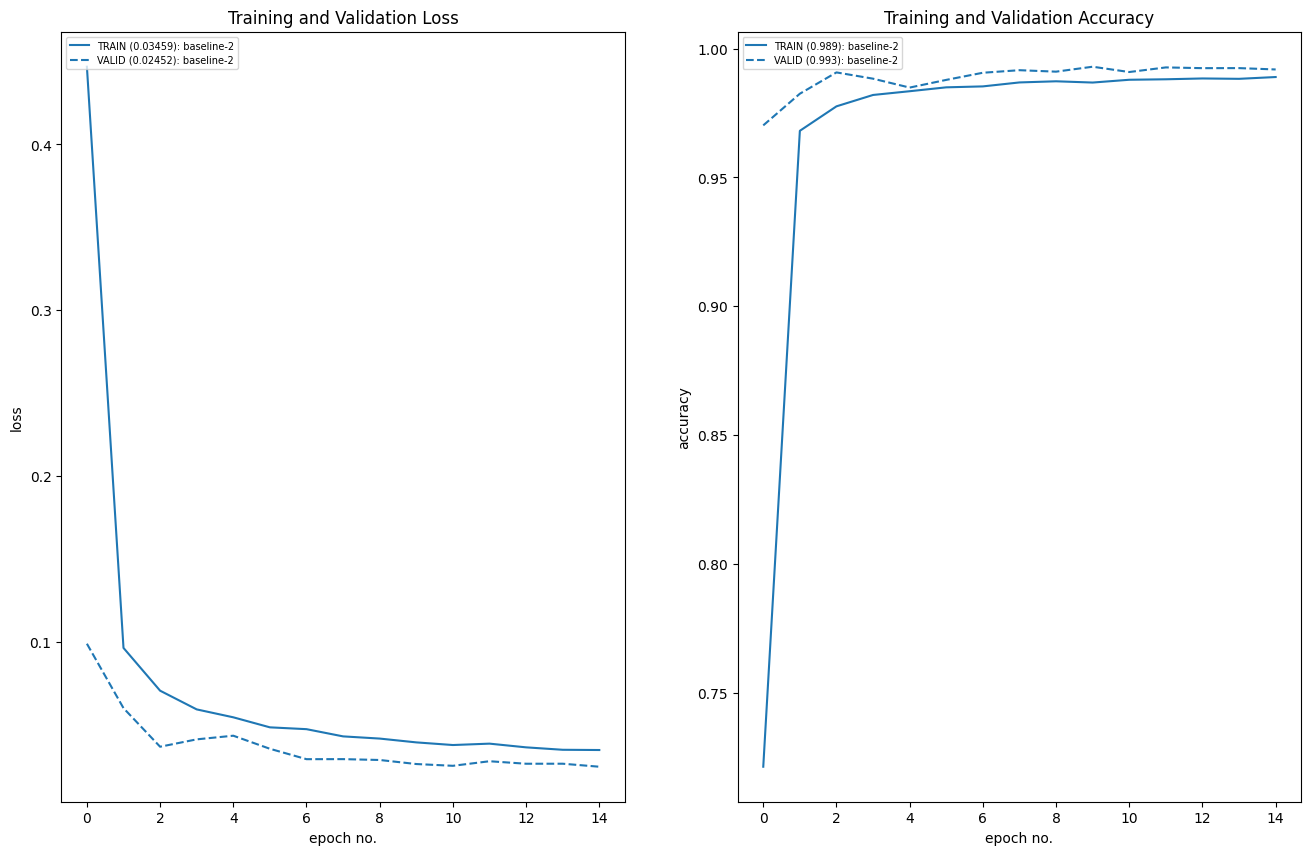

In [33]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline-2'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

Target:
1. Improve the situation of overfitting by adding dropout layers to the model
2. Closed performance metrics for train and test
Results:\
Parameters: 8.9k\
Best Training Accuracy: 98.99\
Best Test Accuracy: 99.3

Analysis:
1. Though train acc metric has comedown but test metrics are better by substantial margin

In [ ]:
b